In [6]:
import tinycss2.tokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import math

import matplotlib.pyplot as plt
import networkx as nx

In GPT positional embedding were fixed to sin/cos of varying freq. but for GPT2 they are params

In [1]:
from transformers import pipeline,set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello World")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [2]:
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('gpt2')
for k,v in model.state_dict().items():
  print(k,v.shape)

model.safetensors:  17%|#7        | 94.4M/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

From scratch

<img src="model.png" alt=model>

In [7]:
class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd)
    self.gelu = nn.GELU()
      #GELU(approximate='tanh')  # gaussian Rectifier approx by tanh (original was slow in tf)
    self.c_proj = nn.Linear(4*config.n_embd, config.n_embd)
      
  def forward(self, x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    return x
  
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size).view(1, 1, config.block_size, config.block_size)))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module): # transformer block
  def __init__(self, config):
    super().__init__()
    self.ln_1 = nn.LayerNorm(config.n_embd)  
    self.attn = CausalSelfAttention(config)
    self.ln_2 = nn.LayerNorm(config.n_embd)  
    self.mlp = MLP(config)
  
  def forward(self, x):
    x = x + self.attn(self.ln_1(x))  # residual connections according to diagram plus ln after attn i.e. ln in residuals
    x = x + self.mlp(self.ln_2(x))
    return x
      
@dataclass
class GPTConfig:   # gpt 124M
  block_size = 1024   # max sequence length
  vocab_size = 50257  # 50k BPE + 256 utf-8 + 1 <|endoftext|>
  n_layer = 12        
  n_head = 12
  n_embd = 768
  dropout = 0.2
  bias = True

class GPT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    
    self.transformer = nn.ModuleDict(     # submodule indexing
      dict(
        wte = nn.Embedding(config.vocab_size, config.n_embd),               # weight token embd                  nn.Embedding -> wrapper for array of nums
        wpe = nn.Embedding(config.block_size, config.n_embd),               # weight pos embd
        h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  # hidden         # index using numeric as per statedict
        ln_f = nn.LayerNorm(config.n_embd),                                 # additional layernorm
      ))
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # classifier/head   n_embd -> vocab size
  
  def forward(self, idx, targets =None):
    B,T = idx.size()
    assert T <= self.config.block_size, f"Block size {self.config.block_size} exceeds block size {self.config.block_size}"
    pos = torch.arange(0,T,dtype=torch.long,device=idx.device) #shape T
    pos_emb = self.transformer.wpe(pos)                        # shape T,n_embd
    tok_emb = self.transformer.wte(idx)                        # shape B,T,n_embd
    x = tok_emb + pos_emb  # broadcast
    
    for block in self.transformer.h:
      x = block(x)
    x = self.transformer.ln_f(x)  # forward final layernorm
    logits = self.lm_head(x)                                  # B,T,vocab_size
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))     # cross entropy doesnt prefer multidimensional inputs   logits = B*T,vocab
    return logits,loss
  
  @classmethod
  def from_pretrained(cls, model_type, override_args=None):  # load pretrained
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig()
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


Starting with Pretrained version


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True


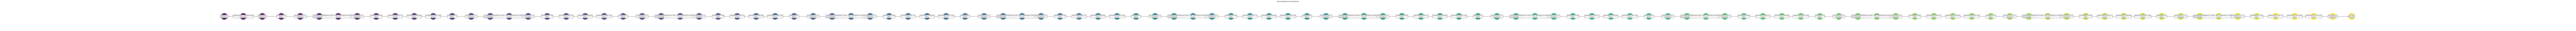

In [13]:
import numpy as np


model = GPT.from_pretrained('gpt2')
layers = list(model.named_modules())[1:]  # Skip top-level model itself


def visualize_model_architecture(model, skip_layers=None, group_layers=False):
    """
    Visualizes a PyTorch model architecture using NetworkX with boxed text.
    
    Parameters:
        model (torch.nn.Module): The PyTorch model to visualize.
        skip_layers (set): A set of layer types (class names as strings) to exclude from visualization.
        group_layers (bool): Whether to merge consecutive layers of the same type.
    """
    if skip_layers is None:
        skip_layers = {"ReLU", "Softmax", "BatchNorm2d", "Dropout"}  # Default skipped layers

    # Extract named layers and filter based on skip_layers
    all_layers = list(model.named_modules())[1:]  # Skip root model
    filtered_layers = []
    
    prev_layer_name, prev_layer_type = None, None

    for name, layer in all_layers:
        layer_type = layer.__class__.__name__

        # Skip layers dynamically
        if layer_type in skip_layers:
            continue

        # Group layers if enabled
        if group_layers and prev_layer_type == layer_type:
            filtered_layers[-1] = (filtered_layers[-1][0] + " → " + name, filtered_layers[-1][1])
        else:
            filtered_layers.append((name, layer_type))

        prev_layer_name, prev_layer_type = name, layer_type

    # Create the graph
    G = nx.DiGraph()
    positions = {}
    num_layers = len(filtered_layers)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))  # Assign different colors

    for i, (name, layer_type) in enumerate(filtered_layers):
        node_label = f"{name}\n({layer_type})"
        G.add_node(node_label)
        positions[node_label] = (i * 2.5, 0)  # Horizontal layout with spacing

        if i > 0:
            prev_label = f"{filtered_layers[i - 1][0]}\n({filtered_layers[i - 1][1]})"
            G.add_edge(prev_label, node_label)

    # Draw the network (without labels)
    plt.figure(figsize=(max(8, len(filtered_layers) * 2.5), 3))
    nx.draw(G, positions, with_labels=False, node_size=2500, node_color=colors,
            edge_color="black", font_size=9, font_weight="bold")

    # Add readable boxed labels
    for node, (x, y) in positions.items():
        plt.text(x, y, node, fontsize=9, ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.title("Neural Network Architecture", fontsize=12)
    plt.show()

visualize_model_architecture(model, group_layers=True)

In [8]:
num_return_sequences = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_length = 30
model.eval()
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello World")
tokens =torch.tensor(tokens,dtype=torch.long,device=device)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences,1) #idx
x = tokens.to(device)

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

while x.size(1) < max_length:
  with torch.no_grad():
    logits = model(x)
    logits = logits[:, -1, :] # take logits at end
    probs = F.softmax(logits, dim=-1) 
    topx_probs, topx_tokens = torch.topk(probs, 50,dim=-1)  #huggingface default /keep top 50
    ix = torch.multinomial(topx_probs,1)  # select from top
    xcol = torch.gather(topx_tokens, -1, ix)  #gather corresponding index
    x = torch.cat((x,xcol),dim=1) # append


for i in range(num_return_sequences):
  tokens = x[i,:max_length].tolist() #rows
  decoded = enc.decode(tokens)
  print(decoded)  # weird?

C:\Users\Haroon\AppData\Local\Temp\ipykernel_13704\218594534.py:50: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)


Hello World, the the the the the the the the the the the the the the the the the the the the the the the the the the the
Hello World, the the the the the the the the the the the the the the the the the the the the the the the the the the the
Hello World, the the the the the the the the the the the the the the the the the the the the the the the the the the the
Hello World, the the the the the the the the the the the the the the the the the the the the the the the the the the the
Hello World, the the the the the the the the the the the the the the the the the the the the the the the the the the the


Now train from scratch

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
B,T = 4,32

In [35]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

data = open('input.txt','r',encoding='utf-8').read()[:1000]   # start with only 1000 chars
tokens = enc.encode(data)
print(tokens[:12]); print(data[:12])

[2514, 9074, 13, 8858, 8270, 11, 4492, 13, 220, 198, 1273, 13]
To Mrs. Savi


In [36]:
# convert to shape B,T instead of single row
import torch

buf =  torch.tensor(tokens[:B*T + 1])  # take one extra for next token in y
x = buf[:-1].view(B,T).to(device)   # exclude last
y = buf[1:].view(B,T).to(device)     # start from second
print(x); print(y)

tensor([[ 2514,  9074,    13,  8858,  8270,    11,  4492,    13,   220,   198,
          1273,    13, 15722,  9228,    11,  4280,    13,  1367,   400,    11,
          1596,    13,   198,  1639,   481, 46201,   284,  3285,   326,   645,
          9336,   468],
        [11791,   262,   198,  9503,   594,   434,   286,   281, 13953,   543,
           345,   423, 11987,   351,   884,  6181,   198,   754,    65,   375,
           654,    13,   314,  5284,   994,  7415,    11,   290,   616,   717,
          4876,   318],
        [  284, 19832,   198,  1820, 13674,  6621,   286,   616,  9490,   290,
          3649,  6628,   287,   262,  1943,   198,  1659,   616, 25971,    13,
           198,    40,   716,  1541,  1290,  5093,   286,  3576,    11,   290,
           355,   314],
        [ 2513,   287,   262,  6483,   286,   198,    47,  7307,  9228,    11,
           314,  1254,   257,  4692,  7840, 28633,   711,  2402,   616, 25839,
            11,   543,   198,  1671,  2114,   616, 25377,  

In [37]:
model = GPT(GPTConfig())
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [39]:
logits, loss = model(x,y)
print(loss)

tensor(11.1579, device='cuda:0', grad_fn=<NllLossBackward0>)
